In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.model_selection import  cross_val_score
from sklearn.preprocessing import StandardScaler 

from sklearn.feature_selection import SelectKBest, f_classif

import yfinance as yf
yf.pdr_override() 
from stockstats import StockDataFrame, wrap
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets, FamaFrenchReader
import pickleshare

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm


from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import black_litterman, risk_models, plotting, objective_functions

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D
import copy
from tensorflow.keras.utils import to_categorical

2023-05-02 03:48:50.285884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# datasets = get_available_datasets()
# print('No. of datasets:{0}'.format(len(datasets)))
# datasets
# # 'F-F_Momentum_Factor_daily'
# # 'F-F_ST_Reversal_Factor_daily'
# # 'F-F_LT_Reversal_Factor_daily'
# # 'Developed_ex_US_3_Factors_Daily'

In [4]:
# Define the start and end dates
startDate = '2016-03-01'
endDate = '2022-01-01'

In [5]:
# FAMA FRENCH

# Define the factors you want to download
factors = 'F-F_Research_Data_5_Factors_2x3_daily'
factors_mom = 'F-F_Momentum_Factor_daily'
factors_st_rev = 'F-F_ST_Reversal_Factor_daily'
factors_lt_rev = 'F-F_LT_Reversal_Factor_daily'

# Create a FamaFrenchReader object with the factors and dates
ff_reader = FamaFrenchReader(symbols=factors, start=startDate, end=endDate)
ff_reader_mom = FamaFrenchReader(symbols=factors_mom, start=startDate, end=endDate)
ff_reader_st_rev = FamaFrenchReader(symbols=factors_st_rev, start=startDate, end=endDate)
ff_reader_lt_rev = FamaFrenchReader(symbols=factors_lt_rev, start=startDate, end=endDate)
# Load the data into a Pandas DataFrame

X_ff_l0 = pd.DataFrame(ff_reader.read()[0])
X_ff_l1 = pd.DataFrame(ff_reader.read()[0]).shift(1)
X_ff_l2 = pd.DataFrame(ff_reader.read()[0]).shift(2)
X_ff_l3 = pd.DataFrame(ff_reader.read()[0]).shift(3)
X_ff_l4 = pd.DataFrame(ff_reader.read()[0]).shift(4)
X_ff_l5 = pd.DataFrame(ff_reader.read()[0]).shift(5)
X_ff_l6 = pd.DataFrame(ff_reader.read()[0]).shift(6)
X_ff_l7 = pd.DataFrame(ff_reader.read()[0]).shift(7)
X_ff_l8 = pd.DataFrame(ff_reader.read()[0]).shift(8)
X_ff_l9 = pd.DataFrame(ff_reader.read()[0]).shift(9)
X_ff_l10 = pd.DataFrame(ff_reader.read()[0]).shift(10)
X_ff_mom = pd.DataFrame(ff_reader_mom.read()[0])
X_ff_st_rev = pd.DataFrame(ff_reader_st_rev.read()[0])
X_ff_lt_rev = pd.DataFrame(ff_reader_lt_rev.read()[0])

X_ff_l = pd.concat([X_ff_l0,
                    X_ff_l1,
                    X_ff_l2,
                    X_ff_l3,
                    X_ff_l4,
                    X_ff_l5,
                    X_ff_l6,
                    X_ff_l7, 
                    X_ff_l8,
                    X_ff_l9,
                    X_ff_l10,
                    X_ff_mom,
                    X_ff_st_rev,
                    X_ff_lt_rev 
                   ], axis = 1)

X_ff_l.columns = ["Mkt-RF_0", "SMB_0", "HML_0", "RMW_0", "CMA_0", "RF_0",
                  "Mkt-RF_1", "SMB_1", "HML_1", "RMW_1", "CMA_1", "RF_1",
                  "Mkt-RF_2", "SMB_2", "HML_2", "RMW_2", "CMA_2", "RF_2",
                  "Mkt-RF_3", "SMB_3", "HML_3", "RMW_3", "CMA_3", "RF_3",
                  "Mkt-RF_4", "SMB_4", "HML_4", "RMW_4", "CMA_4", "RF_4",
                  "Mkt-RF_5", "SMB_5", "HML_5", "RMW_5", "CMA_5", "RF_5",
                  "Mkt-RF_6", "SMB_6", "HML_6", "RMW_6", "CMA_6", "RF_6",
                  "Mkt-RF_7", "SMB_7", "HML_7", "RMW_7", "CMA_7", "RF_7",
                  "Mkt-RF_8", "SMB_8", "HML_8", "RMW_8", "CMA_8", "RF_8",
                  "Mkt-RF_9", "SMB_9", "HML_9", "RMW_9", "CMA_9", "RF_9",
                  "Mkt-RF_10", "SMB_10", "HML_10", "RMW_10", "CMA_10", "RF_10",
                  "Mom", "ST_REV", "LT_REV"]

In [6]:
def z_normalize(data):
   
    # Вычисляем среднее значение и стандартное отклонение для каждой фичи
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    
    # Выполняем Z-нормализацию
    normalized_data = (data - mean) / std
    
    return normalized_data

In [52]:
# df = yf.download('^TYX', startDate, endDate, progress=False )
# df = pd.DataFrame(data=df)
# df

In [7]:
def data_download(ticker,startDate, endDate):
    
    df = yf.download(ticker, startDate, endDate, progress=False )
    df = pd.DataFrame(data=df)
    df = df.drop(['Adj Close'], axis = 1)

    raw_df = df
    raw_df = wrap(raw_df)
    raw_df.init_all()
    
    y_l6 = raw_df.loc[:, 'log-ret'].shift(5)
    y_l5 = raw_df.loc[:, 'log-ret'].shift(4)
    y_l4 = raw_df.loc[:, 'log-ret'].shift(3)    
    y_l3 = raw_df.loc[:, 'log-ret'].shift(2)
    y_l2 = raw_df.loc[:, 'log-ret'].shift(1)
    y_l1 = raw_df.loc[:, 'log-ret'].shift(-1)

    X_ind = raw_df.drop(['log-ret','rate','change'], axis=1)
    dta = pd.concat([X_ind, X_ff_l, y_l6, y_l5, y_l4, y_l3, y_l2, y_l1], axis = 1)


    dta.dropna(inplace = True)

    return(dta)

In [309]:
# # Get bin intervals
# bin_intervals = kb.bin_edges_

# print('Bin intervals:')
# print(bin_intervals)

In [97]:
# plt.hist(y_binned, bins=2, edgecolor='black')
# plt.xlabel('Bin')
# plt.ylabel('Frequency')
# plt.title('Histogram of Binned Data')
# plt.show()

In [70]:
# bin_counts = pd.Series(y_binned.reshape(-1)).value_counts().sort_index()

# print('Bin counts:')
# print(bin_counts)

In [8]:
AAPL = data_download('AAPL',startDate, endDate)
y = AAPL.iloc[:, -1:]
X_add_ff = AAPL.iloc[:,0:-1]

In [10]:
len(y)

1461

  0%|                                                     | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█████▌                                      | 1/8 [04:49<33:48, 289.83s/it]

1/1 [==============================] - 0s 60ms/step


 25%|███████████                                 | 2/8 [09:32<28:32, 285.41s/it]

1/1 [==============================] - 0s 60ms/step


 38%|████████████████▌                           | 3/8 [14:13<23:38, 283.75s/it]

1/1 [==============================] - 0s 62ms/step


 50%|██████████████████████                      | 4/8 [18:51<18:45, 281.44s/it]

1/1 [==============================] - 0s 62ms/step


 62%|███████████████████████████▌                | 5/8 [23:29<14:00, 280.15s/it]

1/1 [==============================] - 0s 60ms/step


 75%|█████████████████████████████████           | 6/8 [28:18<09:25, 282.97s/it]

1/1 [==============================] - 0s 61ms/step


 88%|██████████████████████████████████████▌     | 7/8 [33:05<04:44, 284.57s/it]

1/1 [==============================] - 0s 61ms/step


100%|████████████████████████████████████████████| 8/8 [37:54<00:00, 284.29s/it]

MIN Accuracy Score:  0.483
**************************
MEAN Accuracy Score:  0.565
**************************
MAX Accuracy Score:  0.596


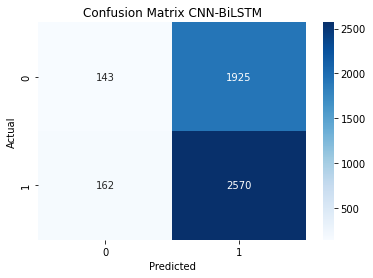

In [178]:
# Define the sliding window parameters
train_window = 1200
test_window = 30


prices_total = pd.DataFrame()
pred_total = pd.DataFrame()
y_train_total = pd.DataFrame()
y_test_total = pd.DataFrame()
ret_total = pd.DataFrame()
ret_test_total = pd.DataFrame()


input_cols = X_add_ff.columns
market_prices = data_download('^GSPC', startDate, endDate)['close']

tickers =['NEE', 'ORCL', 'LIN', 'COST', 'PG', 'CVX', 'ADBE', 'LLY', 'NOW', 'ADP',
       'AMAT', 'SPGI', 'ABBV', 'TMO', 'INTU', 'LOW', 'GOOGL', 'ACN', 'GOOG', 'HD']

# tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'JPM', 'JNJ', 'V',
#            'WMT', 'PG', 'BAC', 'UNH', 'NVDA', 'MA', 'HD', 'DIS', 'VZ', 'CRM', 'PYPL', 
#            'KO', 'ADBE', 'INTC', 'PFE', 'ABT', 'T', 'BMY', 'MRK', 'ACN', 'XOM',
#            'CSCO', 'CVX', 'BA', 'CMCSA', 'WFC', 'PEP', 'GOOG', 'ORCL', 'COST', 'MCD', 
#            'ABBV', 'MDT', 'NKE', 'AMGN', 'TXN', 'NEE', 'LLY', 'MMM', 'HON', 'SBUX', 'NVS', 
#            'LMT', 'RTX', 'UNP', 'TMUS', 'DHR', 'UPS', 'IBM', 'BABA', 'QCOM', 'AMT', 
#            'TMO', 'AVGO', 'CVS', 'LIN', 'DE', 'AXP', 'CAT', 'LRCX', 'WBA', 
#            'GE', 'SO', 'LOW', 'D', 'MO', 'C', 'SPGI', 'COP', 'BLK', 'NOW', 
#            'CME', 'GS', 'INTU', 'FDX', 'VRTX','CI', 'ADP', 'TGT',
#            'AMAT', 'DUK', 'TJX', 'GM', 'MS', 'SCHW']


# Loop over the sliding windows

for i in tqdm(range(0, len(y) - train_window - test_window + 1, test_window)):
    
    pred_class_in_window = pd.DataFrame()    
    y_train_in_window = pd.DataFrame()
    y_test_in_window = pd.DataFrame()
    ret_in_window = pd.DataFrame()
    prices_in_window = pd.DataFrame()
    ret_test_in_window = pd.DataFrame()
#     ret_for_mrtz_total = pd.DataFrame()
    
    for ticker in tickers:
        
        #data download and preprocessing
        current_dataset = data_download(ticker,startDate, endDate)
        y = current_dataset.iloc[:, -1:]
        X = current_dataset.iloc[:,0:-1]

    
        # Perform feature selection
        k = 20  # Number of top features to select
        selector = SelectKBest(score_func=f_classif, k=k)  
        X_selected = pd.DataFrame(selector.fit_transform(X, y))
        
        #разбиваю доходности на два класса
        y_classified = []
        #y = np.array(y).reshape(-1,1)

        for val in y.values:
            if val > 0:
                y_classified.append([1,0])
            elif val <= 0:
                y_classified.append([0,1])

        #обработка данных
        sc = StandardScaler()

        data = X_selected.values
        data_scaled = sc.fit_transform(data)

        sequence_length = 10
        X = []
        data_y = []

        for g in range(sequence_length, len(data_scaled)):
            X.append(data_scaled[g - sequence_length:g])
            data_y.append(y_classified[g])

        data_y = np.array(data_y)
        X = np.array(X)
        X_train =  X[i:i+train_window, :]
        X_test =  X[i+train_window:i+train_window+test_window]
        y_train = data_y[i:i+train_window]
        y_test = data_y[i+train_window:i+train_window+test_window]

        
        #построение модели
        model = Sequential([
        Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(X_train.shape[1],
                                                                          X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Bidirectional(LSTM(units=50, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(units=50, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(units=50)),
        Dropout(0.2),
#         Dense(units=2, activation='softmax')
        Dense(units=2, activation= 'sigmoid')   
        ])


        model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy',
                      metrics = ['accuracy'], run_eagerly=True)
        model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test,y_test), verbose = 0)

        # Evaluate the model
        pred_class = model.predict(X_test)
        y_pred = model.predict(X_test)

        #перевод непрерывных значений прогноза в классы и расчет accuracy
        y_pred_classes = []
        #1 - рост, 0 - падение
        for yyy in y_pred:
            if yyy[0] >= 0.5:
                y_pred_classes.append(1)
            elif yyy[0] < 0.5:
                y_pred_classes.append(0)
        
        #y = np.array(y).reshape(-1,1)
        y_cl_test = []
        for yyy in y_test:
            if yyy[0] >= 0.5:
                y_cl_test.append(1)
            elif yyy[0] < 0.5:
                y_cl_test.append(0)
        
#         pred_class = pd.DataFrame(y_pred_classes)
        pred_class_in_window[ticker] = pd.DataFrame(y_pred_classes)
        y_train_in_window[ticker] = y.iloc[i:i+train_window]
        y_test_in_window[ticker] = y_cl_test
        prices_in_window[ticker] = current_dataset.iloc[i:i+train_window, :]['close']
        ret_test_in_window[ticker] = y.iloc[i+train_window:i+train_window+test_window]
        
        #predictions to views
        
        y_cl_train= []
        for yyy in y_train:
            if yyy[0] >= 0.5:
                y_cl_train.append(1)
            elif yyy[0] < 0.5:
                y_cl_train.append(0)
                
        y_0 = []
        y_1 = []
        yy = np.array(pd.concat([pd.DataFrame(y.iloc[i:i+train_window].values), pd.DataFrame(y_cl_train)], axis = 1))
        for k in range(len(y_train)):
            if yy[k,1] == 1:
                y_1.append(yy[k,0])
            else:
                y_0.append(yy[k,0])

        
#         for j in range(len(pred_class)):
#             if int(pred_class.iloc[j]) == 0:
#                 pred_ret.append(np.mean(y_0))
#             else:
#                 pred_ret.append(np.mean(y_1))
                
#         ret_in_window[ticker]= pred_ret
        
        pred_class = pd.DataFrame(pred_class)
        pred_ret = []
        for j in range(len(pred_class)):
            
            if pred_class.iloc[j,0] > 0.5:
            
                pred_ret.append(np.mean(y_1[-40:]))
                                
            else:
                pred_ret.append(np.mean(y_0[-40:]))     

        ret_in_window[ticker]= pred_ret
        
                      
    #aggregate inf from loop
    pred_total = pd.concat([pred_total,pred_class_in_window], axis = 0) 
#     pred_ret = pd.DataFrame(pred_ret)
    ret_total = pd.concat([ret_total,ret_in_window], axis = 0)
    y_train_total = pd.concat([y_train_total,pd.DataFrame(y_train_in_window.mean()).T], axis = 0) 
    y_test_total = pd.concat([y_test_total,y_test_in_window.reset_index(drop = True)], axis = 0) 
    
    ret_test_total = pd.concat([ret_test_total, ret_test_in_window], axis = 0)

acc = []
for i in range(len(tickers)):
    
    acc.append(accuracy_score(y_test_total.iloc[:,i], pred_total.iloc[:,i]))

    
print("MIN Accuracy Score: ", round(np.min(acc),3))
print("**************************")
print("MEAN Accuracy Score: ", round(np.mean(acc),3))
print("**************************")
print("MAX Accuracy Score: ", round(np.max(acc),3))
# ret_test_total = ret_test_total.T
dataaa = {0:acc}
acc_df = pd.DataFrame.from_dict(dataaa, orient='index', columns = tickers)
# acc_df

# Create confusion matrix
y_true = np.array(y_test_total).flatten()
y_pred = np.array(pred_total).flatten()

cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix CNN-BiLSTM')

# Show the plot
plt.savefig('confusion_matrix_CNN-BiLSTM.jpeg', dpi=300)
plt.show()

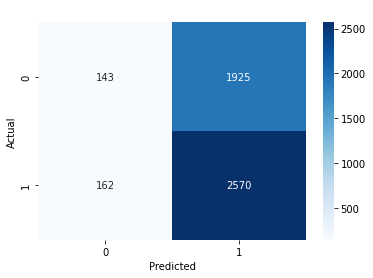

In [221]:
# Create confusion matrix
y_true = np.array(y_test_total).flatten()
y_pred = np.array(pred_total).flatten()

cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(' ')

# Show the plot
plt.savefig('confusion_matrix_CNN-BiLSTM.jpeg', dpi=300)
plt.show()

In [225]:
from scipy import stats

# Задаем выборку из наблюдений
data = acc

# Вычисляем среднее значение и стандартное отклонение выборки
mean = np.mean(data)
std_dev = np.std(data, ddof=1)  # ddof=1 означает, что стандартное отклонение вычисляется по выборке (n-1)

# Задаем уровень доверия
confidence_level = 0.99

# Вычисляем количество степеней свободы
degrees_of_freedom = len(data) - 1

# Вычисляем критическое значение t-статистики
t_critical = stats.t.ppf((1 + confidence_level) / 2, df=degrees_of_freedom)

# Вычисляем стандартную ошибку
standard_error = std_dev / np.sqrt(len(data))

# Вычисляем доверительный интервал
lower_bound = mean - t_critical * standard_error
upper_bound = mean + t_critical * standard_error

# Выводим результат
print(f"Доверительный интервал с уровнем доверия {confidence_level}: ({round(lower_bound, 3)},{round(upper_bound,3)})")

Доверительный интервал с уровнем доверия 0.99: (0.549,0.581)


In [209]:
len(np.array(y_0).flatten()), len(np.array(y_1).flatten())

(541, 659)

In [192]:
top_10 = acc_df.T.sort_values(by = 0).tail(20)
print(top_10.T.columns)

Index(['CVX', 'COST', 'LIN', 'PG', 'NEE', 'LLY', 'ORCL', 'ADBE', 'ABBV', 'ADP',
       'SPGI', 'TMO', 'AMAT', 'NOW', 'LOW', 'GOOGL', 'ACN', 'GOOG', 'INTU',
       'HD'],
      dtype='object')


In [193]:
top_10.T

,CVX,COST,LIN,PG,NEE,LLY,ORCL,ADBE,ABBV,ADP,SPGI,TMO,AMAT,NOW,LOW,GOOGL,ACN,GOOG,INTU,HD
0,0.483333,0.5375,0.545833,0.545833,0.554167,0.554167,0.558333,0.558333,0.566667,0.566667,0.575,0.575,0.579167,0.579167,0.579167,0.583333,0.5875,0.5875,0.591667,0.595833


In [93]:
# ret_test_total.to_csv('test.csv', encoding='utf-8')
# ret_total.to_csv('CNN-BiLSTM.csv', encoding='utf-8')

In [206]:
b = ret_test_total.values.flatten()

a = ret_total.values.flatten()
ab = pd.concat([pd.DataFrame(a),pd.DataFrame(b)], axis = 1)
ab.corr()

,0,0
0,1.00000,0.00095
0,0.00095,1.00000


In [194]:
corr_matrix = []
for t in tickers: 
    b =ret_test_total[t].values
    # b =y_test_total.values.flatten()
    a = pred_total[t].values
    ab = pd.concat([pd.DataFrame(a),pd.DataFrame(b)], axis = 1)
    c = ab.corr()
    corr_matrix.append(c.iloc[0,1])
# corr_matrix.columns = tickers  
print(corr_matrix)

[nan, 0.13657803265063032, -0.010095081617717458, -0.057234918056621495, -0.12459954242749337, -0.05640329562051339, nan, -0.05458834105101409, -0.0904036648426477, nan, 0.012410162673184465, 0.12492949249074665, nan, nan, 0.020036782820269043, nan, -0.012262067606799551, nan, -0.05032639373044685, 0.05846058871624827]


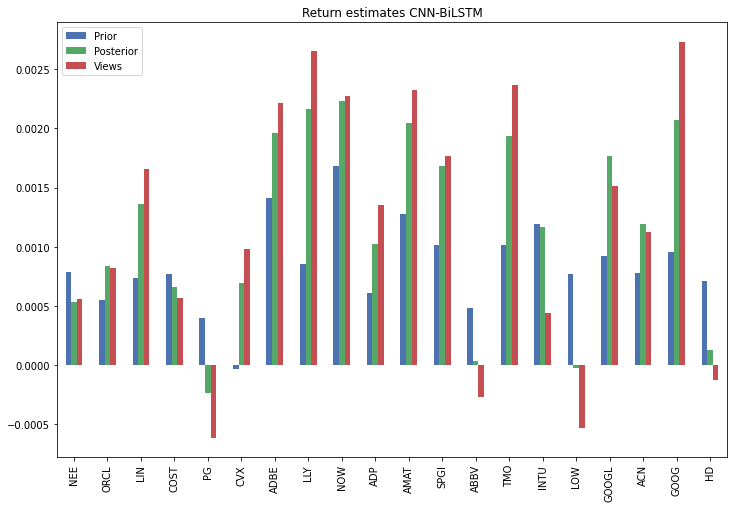

In [204]:
prices = pd.DataFrame() 
w_bl_total = pd.DataFrame()
w_m_total = pd.DataFrame()
market_prior_total = pd.DataFrame() 
y_train_total_all = pd.DataFrame()
ret_bl_total = pd.DataFrame()
view_total = pd.DataFrame()

confidences = []
for c in range(len(tickers)):
    confidences.append(0.8)


#prices for cov matrix
for ticker in tickers:
    current_dataset = data_download(ticker,startDate, endDate)
    prices[ticker] = current_dataset['close']
    
#creating market prior total list
for i in range(len(y_train_total)):
    for j in range(test_window):
        y_train_total_all = pd.concat([y_train_total_all,
                                       pd.DataFrame(y_train_total.iloc[i,:]).T], axis = 0)

        
cov_window = 252
# y_train_total_all = y_train_total_all    

#Black-Litterman part
ret_total=ret_total.reset_index(drop=True)    

delta_window = 756

for k in range(len(ret_total)):
    
    market_prior = y_train_total_all.iloc[k, :].values
    market_prior_total = pd.concat([market_prior_total,
                                    pd.DataFrame(market_prior, index = tickers).T], axis = 0)
    
    prices_in_window = prices.iloc[k + train_window - cov_window:k+train_window, :]
    
    
#     S = np.sqrt(prices_in_window.cov())
    S = risk_models.CovarianceShrinkage(prices_in_window,returns_data=False,
                                        frequency=1, log_returns=False).ledoit_wolf()
    
    delta = black_litterman.market_implied_risk_aversion(market_prices[k+train_window-delta_window:k+train_window])
#     delta = 100
    
    #creating views for BL model
    viewdict = {}
    for t in tickers:
        viewdict[t] = ret_total.loc[k,t] 
    view_df = pd.DataFrame(viewdict, index = [0])
    view_total = pd.concat([view_total,view_df], axis = 0)

    bl = BlackLittermanModel(cov_matrix = S,
                             pi = market_prior,
                             absolute_views=viewdict,
                             omega="idzorek",
#                              risk_aversion = delta,
                             view_confidences=confidences,
                             tau = 1)

    #Posterior estimate of returns
    ret_bl = bl.bl_returns()
    ret_bl_total = pd.concat([ret_bl_total, pd.DataFrame(ret_bl).T], axis = 0)
    

    S_bl = bl.bl_cov()                                 
    ef = EfficientFrontier(ret_bl, S_bl)
    ef.add_objective(objective_functions.L2_reg, gamma = 0.01)
#     bl.optimize().add_constraint(lambda x : x >= -1)
#     ef.add_constraint(lambda x : x >= -1)
#     ef.add_constraint(lambda x : x <= 1)
    ef.efficient_risk(target_volatility = 0.018, market_neutral=False)
#     ef.min_volatility()
    weights = ef.clean_weights()
#     weights = bl.clean_weights()
#     weights = bl.bl_weights()
    w_bl = pd.DataFrame(weights, index = [0])
    w_bl_total = pd.concat([w_bl_total, w_bl], axis = 0)
    
    
    #Market
    ef_m = EfficientFrontier(market_prior, S)
#     ef_m.add_objective(objective_functions.L2_reg, gamma = 0.01)
#     ef_m.add_constraint(lambda x : x >= -1)
#     ef_m.add_constraint(lambda x : x <= 1)
    ef_m.efficient_risk(target_volatility = 0.018, market_neutral=False)
#     ef_m.min_volatility()
    weights_m = ef_m.clean_weights()
    w_m = pd.DataFrame(weights_m, index = [0])
    w_m_total = pd.concat([w_m_total, w_m], axis = 0)
    
    #table for compare estimaded returns 
#     rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
#                                index=["Prior", "Posterior", "Views"]).T
    
rets_df_total = pd.DataFrame([market_prior_total.mean(), ret_bl_total.mean(), view_total.mean()],
                               index=["Prior", "Posterior", "Views"]).T
# print(rets_df_total)
rets_df_total.plot.bar(figsize=(12,8))
plt.title('Return estimates CNN-BiLSTM')
# Show the plot
plt.savefig('Return estimates CNN-BiLSTM.jpeg', dpi=300)

In [203]:
bl_portf_rets = []
mrkt_portf_rets = []
naive_portf_rets = []

#naive

w_naive = []
for t in tickers:
    w_naive.append(1/len(tickers))
w_naive = pd.DataFrame(w_naive).T

w_naive_total = pd.DataFrame()
for i in range(len(w_bl_total)):
    w_naive_total = pd.concat([w_naive_total,w_naive], axis = 0)
w_naive_total.columns = tickers

for i in range(len(ret_test_total.iloc[:,0])):
    
    bl_portf_rets.append(ret_test_total.iloc[i,:].T.dot(w_bl_total.iloc[i,:]))
    mrkt_portf_rets.append(ret_test_total.iloc[i,:].T.dot(w_m_total.iloc[i,:]))
    naive_portf_rets.append(ret_test_total.iloc[i,:].T.dot(w_naive_total.iloc[i,:]))
    
std_bl = np.std(bl_portf_rets)
std_m = np.std(mrkt_portf_rets)
std_n = np.std(naive_portf_rets)
    
itog = pd.DataFrame(
    {'BL': [round(sum(bl_portf_rets),4),round(std_bl,4), round(sum(bl_portf_rets)/std_bl,4)],
     'MRKT': [round(sum(mrkt_portf_rets),4), round(std_m, 4), round(sum(mrkt_portf_rets)/std_m,4)],
     'NAIVE': [round(sum(naive_portf_rets),4), round(std_n, 4), round(sum(naive_portf_rets)/std_n,4)]}, 
    index = ['C_ret: ','Std: ',  'SR: '])
print(itog)

              BL    MRKT    NAIVE
C_ret:    0.2741  0.1279   0.3122
Std:      0.0094  0.0140   0.0086
SR:      29.0135  9.1235  36.3983


In [222]:
df_rebalancing_bl = pd.DataFrame(np.nan, index=w_bl_total.index, columns=w_bl_total.columns)
for i in range(1, len(w_bl_total)):
    df_rebalancing_bl.iloc[i] = w_bl_total.iloc[i] - w_bl_total.iloc[i-1]

# print the result
rebalancing_bl = abs(df_rebalancing_bl).sum().sum()

df_rebalancing_m = pd.DataFrame(np.nan, index=w_m_total.index, columns=w_m_total.columns)
for i in range(1, len(w_bl_total)):
    df_rebalancing_m.iloc[i] = w_m_total.iloc[i] - w_m_total.iloc[i-1]

# print the result
rebalancing_m = abs(df_rebalancing_m).sum().sum()


rebalancing_bl, rebalancing_m

(21.00079, 7.798199999999999)

In [16]:
ind = y.index[train_window:train_window + test_window*((len(y) - train_window)//test_window)].values

In [98]:
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
%matplotlib inline

In [158]:
bl_returns = pd.Series(bl_portf_rets, index = ind)
m_returns = pd.Series(mrkt_portf_rets, index = ind)
bl_returns.index = bl_returns.index.tz_localize('utc')
m_returns.index = m_returns.index.tz_localize('utc')

Start date,2020-12-17
End date,2021-11-30
Total months,11
,Backtest
Annual return,11.558%
Cumulative returns,10.979%
Annual volatility,22.309%
Sharpe ratio,0.60
Calmar ratio,0.84
Stability,0.65
Max drawdown,-13.692%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.69,2021-01-19,2021-03-05,2021-06-18,109
1,12.35,2021-11-03,2021-11-30,NaT,NaN
2,12.28,2021-09-02,2021-10-01,2021-10-28,41
3,2.90,2021-08-04,2021-08-10,2021-08-19,12
4,2.07,2021-10-28,2021-10-29,2021-11-03,5


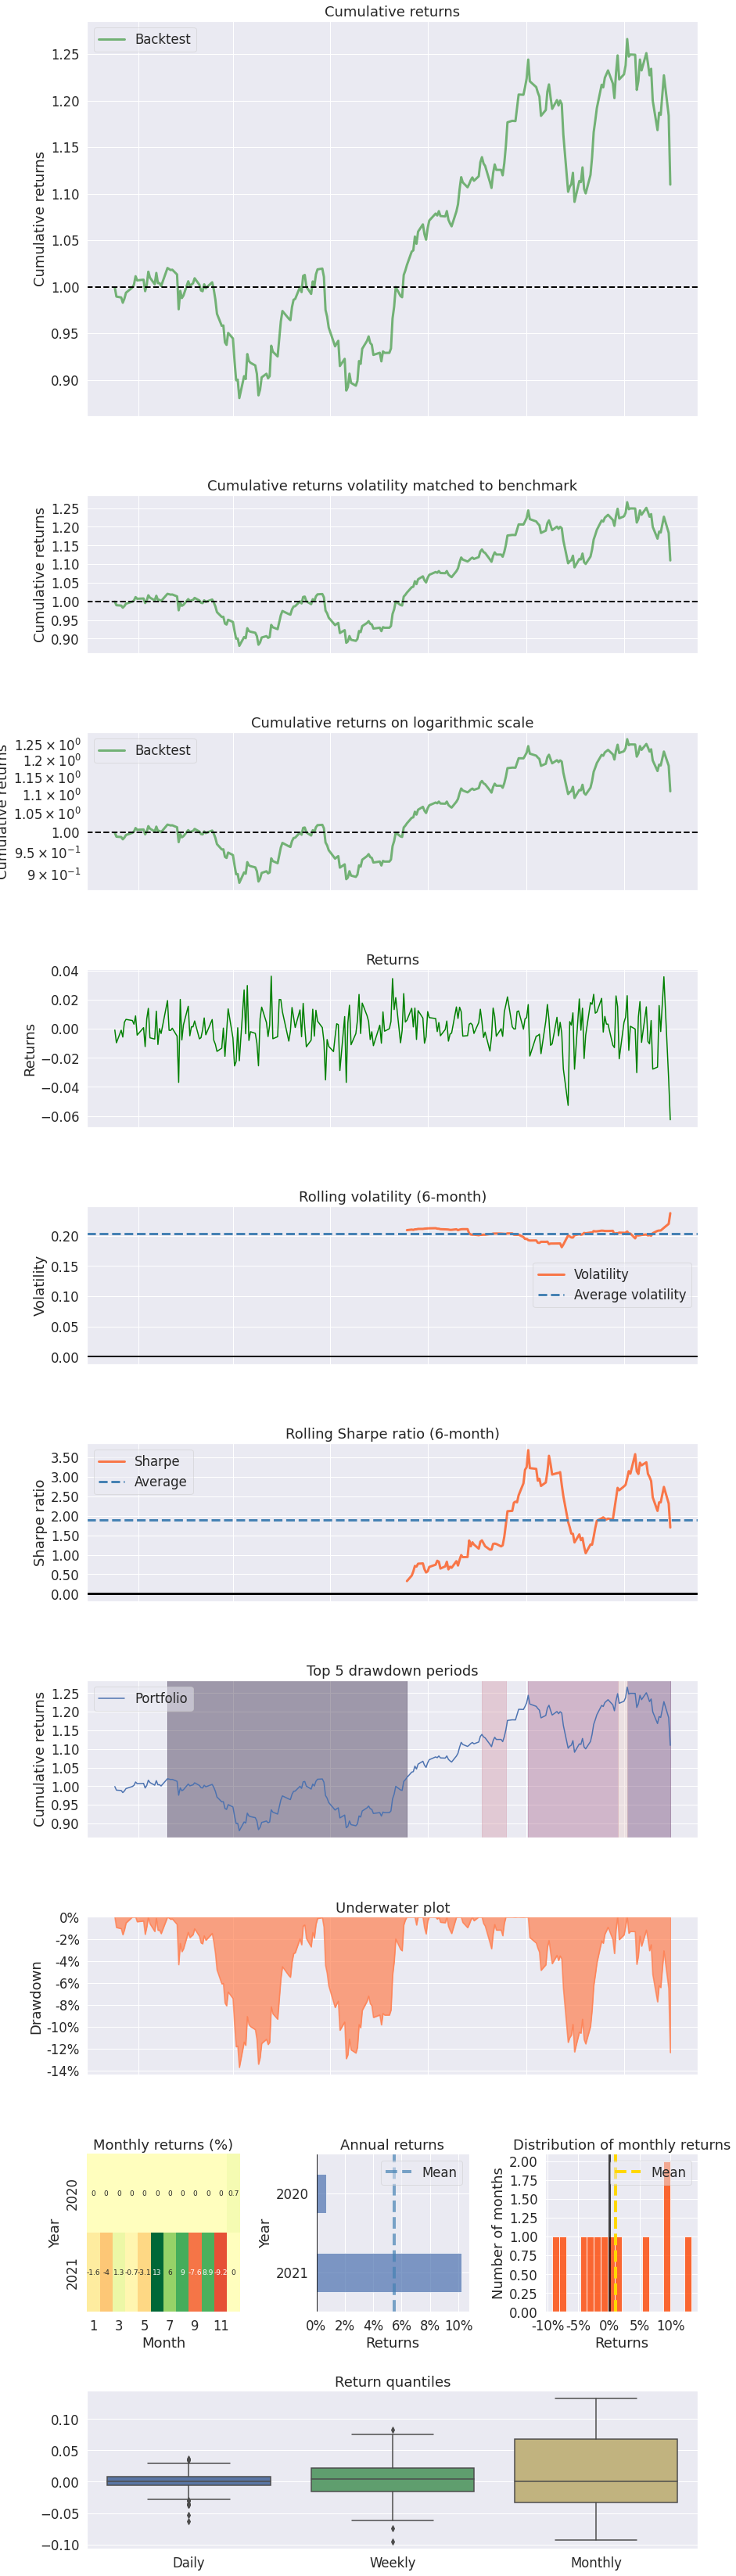

In [205]:
import matplotlib
matplotlib.use('Agg')

f = pf.create_returns_tear_sheet(m_returns, return_fig=True)

Start date,2020-12-17
End date,2021-11-30
Total months,11
,Backtest
Annual return,32.988%
Cumulative returns,31.195%
Annual volatility,14.176%
Sharpe ratio,2.08
Calmar ratio,4.48
Stability,0.91
Max drawdown,-7.359%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.36,2021-01-22,2021-03-03,2021-03-31,49
1,6.97,2021-09-02,2021-10-01,2021-10-18,33
2,5.73,2021-04-15,2021-05-11,2021-06-09,40
3,3.75,2021-11-18,2021-11-30,NaT,NaN
4,1.68,2021-11-03,2021-11-09,2021-11-15,9


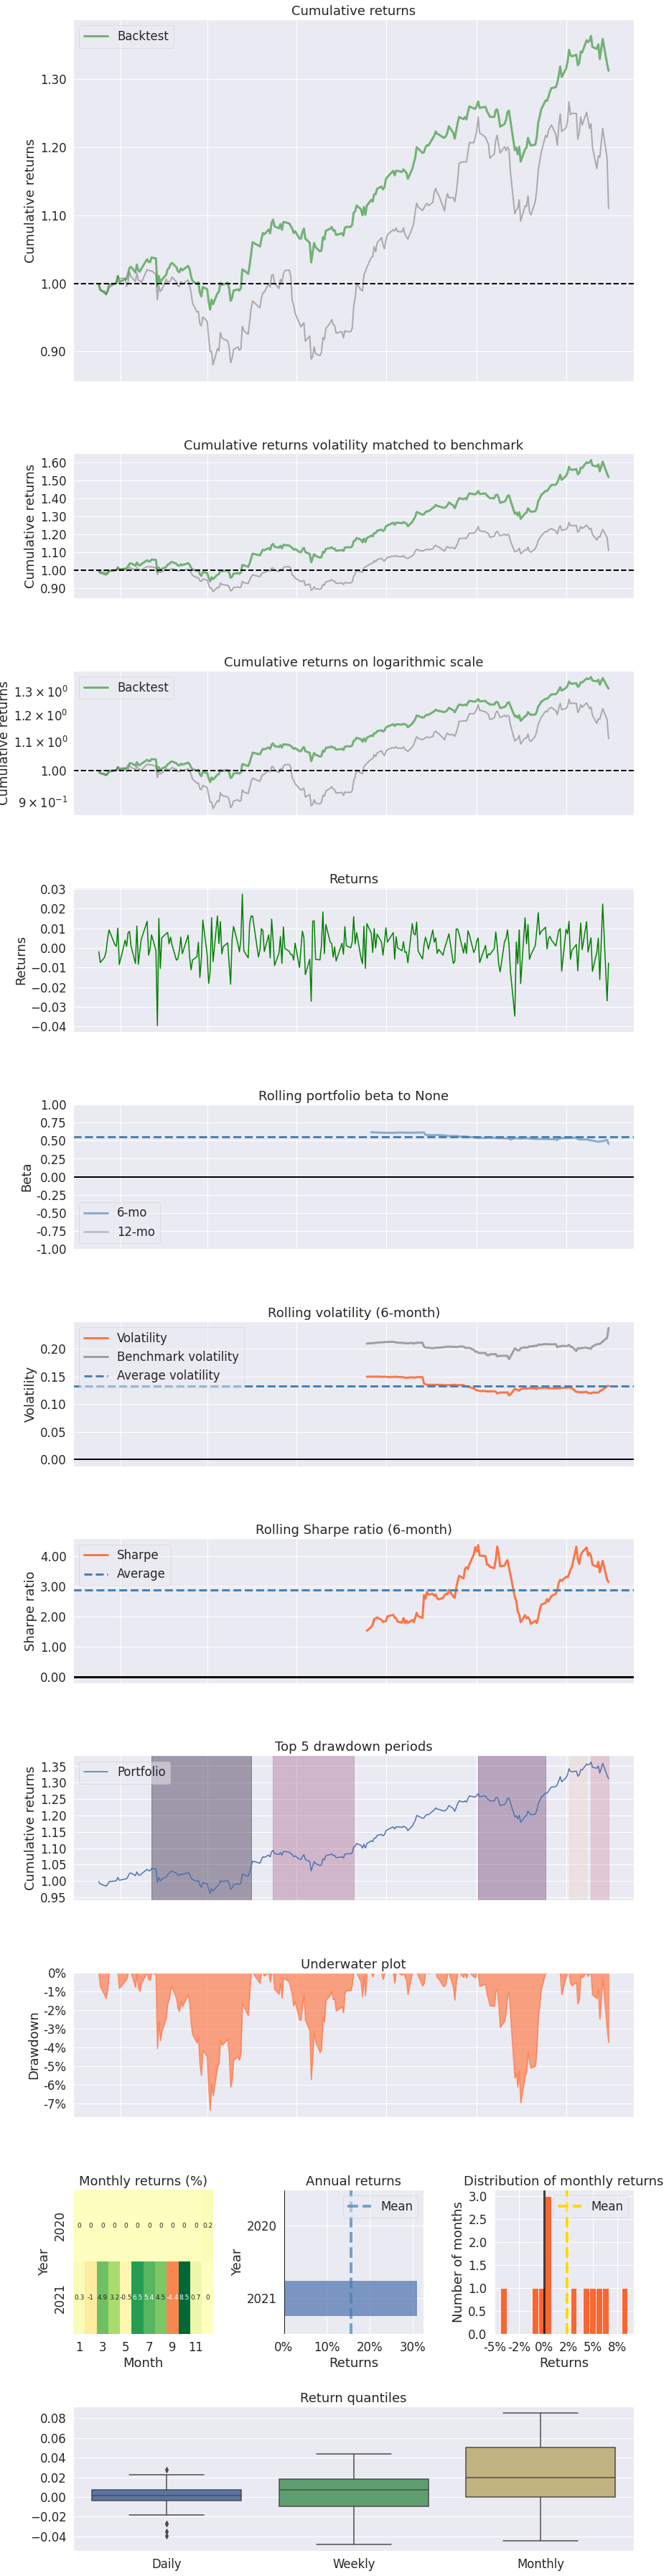

In [198]:
import matplotlib
matplotlib.use('Agg')

f = pf.create_returns_tear_sheet(bl_returns, benchmark_rets=m_returns, return_fig=True)

# # f.savefig('pyfolio_returns_catboost.jpeg', dpi=300)

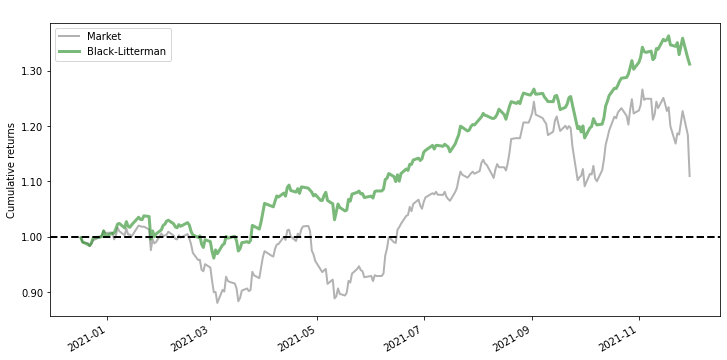

In [215]:
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_rolling_returns(bl_returns,m_returns, ax=ax, legend_loc='best')
ax.legend(['Market', 'Black-Litterman'])
plt.title(' ')
plt.savefig('Cumulative_Returns_CNN-BiLSTM.jpeg', dpi=300)

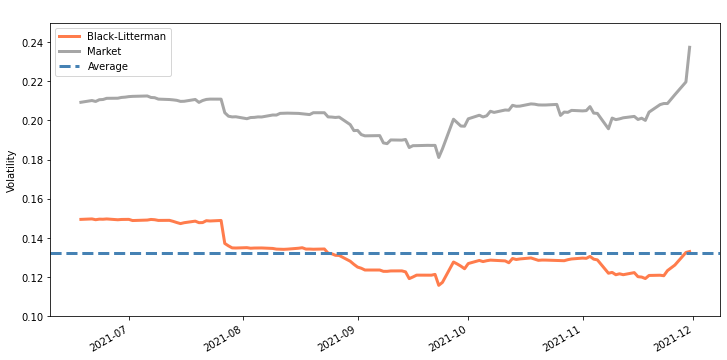

In [216]:
# pf.plotting.plot_rolling_returns(bl_returns, m_returns)
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_rolling_volatility(bl_returns, m_returns, rolling_window=126)
ax.legend(['Black-Litterman', 'Market', 'Average'])
plt.title(' ')
ax.set_ylim([0.1, 0.25])
plt.savefig('rolling_volatility_CNN-BiLSTM.jpeg', dpi=300)

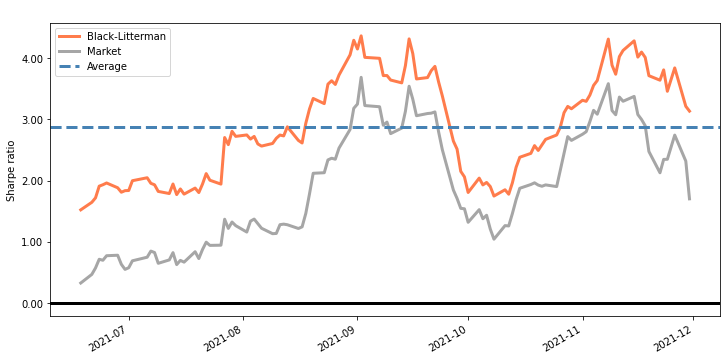

In [217]:
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_rolling_sharpe(bl_returns,m_returns, figsize=(12,6))
ax.legend(['Black-Litterman', 'Market', 'Average'])
plt.title(' ')
plt.savefig('Rolling Sharpe ratio (6-month) CNN-BiLSTM.jpeg', dpi=300)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.69,2021-01-19,2021-03-05,2021-06-18,109
1,12.35,2021-11-03,2021-11-30,NaT,NaN
2,12.28,2021-09-02,2021-10-01,2021-10-28,41
3,2.90,2021-08-04,2021-08-10,2021-08-19,12
4,2.07,2021-10-28,2021-10-29,2021-11-03,5


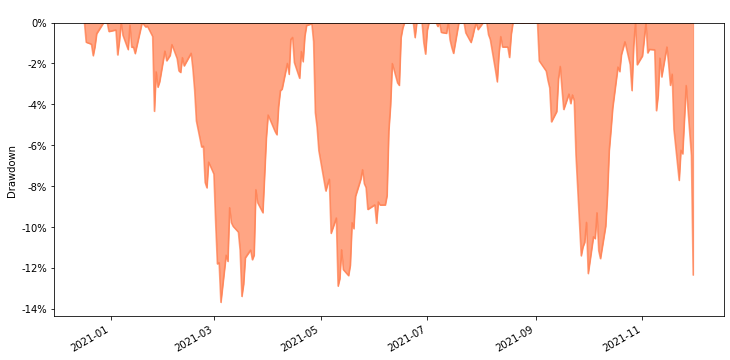

In [218]:
pf.plotting.show_worst_drawdown_periods(m_returns, top=5)
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_drawdown_underwater(m_returns, figsize=(12,6))
plt.title(' ')
plt.savefig('Underwater Market portfolio CNN-BiLSTM.jpeg', dpi=300)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.36,2021-01-22,2021-03-03,2021-03-31,49
1,6.97,2021-09-02,2021-10-01,2021-10-18,33
2,5.73,2021-04-15,2021-05-11,2021-06-09,40
3,3.75,2021-11-18,2021-11-30,NaT,NaN
4,1.68,2021-11-03,2021-11-09,2021-11-15,9


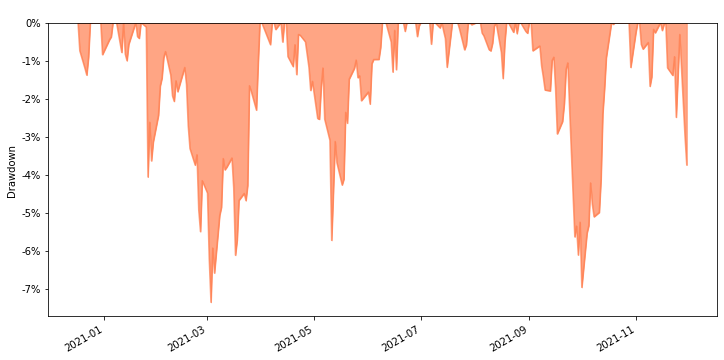

In [220]:
pf.plotting.show_worst_drawdown_periods(bl_returns, top=5)
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_drawdown_underwater(bl_returns, figsize=(12,6))
plt.title(' ')
plt.savefig('Underwater Black-littarman portfolio CNN-BiLSTM.jpeg', dpi=300)